# RoofTop Solar Panel Detection using Deep Learning

---

    
**Project Purpose: ML for Earth Observation Project**
**Project Name: RoofTop Solar Panel Detection using Deep Learning**

---

<img src = "https://miro.medium.com/max/1400/1*QJEnWss0ENhft6hmpuYU0A.webp" width = 55%>

## Workflow of this notebook
**1)** [Introducing the Problem](#h1)      
**2)** [Understanding the Dataset](#h2)    
**3)** [Importing necessary libraries and modules for this notebook](#h3)      
**4)** [Exploratory Analysis & Data Scaling](#h4)           
**5)** [Building & Tuning our CNN Model](#h5)   
**6)** [Model Evaluation & Results](#h6)        


# Introduction to the problem <a name ="h1"></a>

### Why should solar panels be detected?

<p align="justify">Presently, 1% of the electricity produced worldwide comes from solar energy. In fact, predictions for solar energy production indicate a possible 65-fold increase in output by 2050, making solar energy one of the world's greatest sources of energy at that point. Thirty percent of this energy is thought to be produced by solar photovoltaic, or solar PV, power systems mounted on rooftops. Solar PV power has already started to take on a more and bigger part in the generation of electricity in the US in recent years. Solar energy production increased by 75,123 GWh or 39 times between 2008 and 2017, or a 39-fold increase.

<p align="justify">Here's an overview on the global growth -

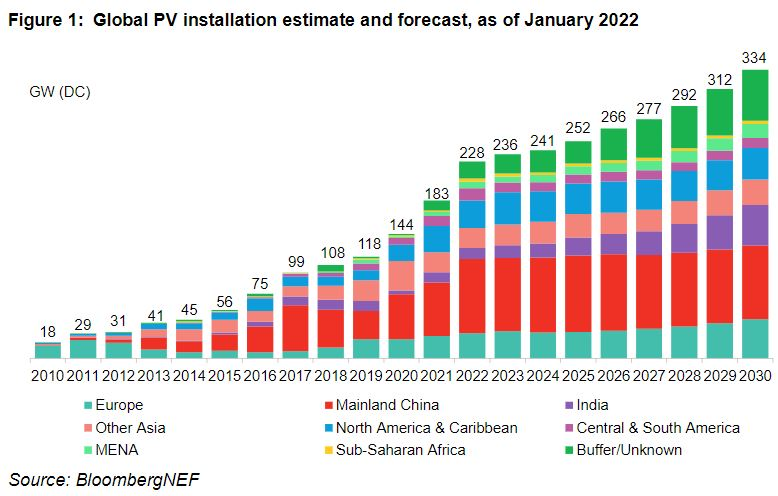

Credits : Bloomberg

<p align="justify">Granular data on distributed rooftop solar PV is becoming increasingly important as solar photovoltaic (PV) becomes a significant segment of the energy industry. An imagery-based solar panel recognition algorithm that can be used to create detailed databases of installations and their power capacity would be extremely helpful to solar power suppliers and consumers, urban planners, grid system operators, and energy policy makers. The fact that solar panel installers typically keep installation details to themselves is another factor in solar panel detection. A well-known solar panel detecting technique or algorithm is therefore urgently needed. However, there hasn't been much effort done to identify solar panels in aerial or satellite photographs.

<p align="justify">We first require a labelled data-set of satellite images in order to create an algorithm that can recognise solar panels from aerial or satellite imagery.


# Understanding the Dataset<a name ="h2"></a>

##### <center> <b>Here are a few snippets from the dataset - Images containing Solar Panels </b>

<center> <img src = "https://anna-berman.com/images/solarPV-PV.png" width = 75%>

##### <center> <b>Here are a few snippets from the dataset - Images NOT containing Solar Panels</b>
<center> <img src = "https://anna-berman.com/images/solarPV-PVno.png" width = 75%>


<p align="justify">When examining the photographs themselves, it is clear that solar panels frequently have rectangular shapes with distinct angles and borders. However, the whole pictures that include solar PV do not necessarily have a same structure. The solar panels are not always at the centre of images, which come in a range of sizes and hues. Additionally, the background scenery in the photographs of the two classes is also not uniform. Both classes contain illustrations of home swimming pools, pavement, grass, and rooftops. A model should also be able to predict the same class independent of the orientation of each image.

#Importing necessary libraries and modules for this notebook<a name ="h3"></a>

In [1]:
# IMPORT REQUIRED LIBRARIES AND FUNCTIONS


'''Data Handling & Linear Algebra'''
import numpy as np
import pandas as pd

'''Visualisation'''
import matplotlib.pyplot as plt
import matplotlib as mpl
from pylab import rcParams
import seaborn as sns

'''Data Analysis'''
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

'''Manipulating Data and Model Building'''
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import GlobalMaxPooling2D
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Add
from keras.models import Sequential

2025-04-16 08:54:53.585006: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744793693.883705      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744793693.966675      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# define dataset directories - the below links won't work if you haven't placed 'data' folder in your 'Main Drive'
DIR_TRAIN_IMAGES = "/kaggle/input/dataset/training-20250413T091550Z-001/training"
DIR_TRAIN_LABELS = "/kaggle/input/dataset/labels_training - labels_training.csv"

#Exploratory Analysis & Data Scaling<a name ="h4"></a>




In [3]:
pd.read_csv(DIR_TRAIN_LABELS).head()

id  label
0   0      0
1   1      0
2   2      1
3   3      1
4   4      1

- id are names of the image before tif
- label has two values:
  - 0: No solar panels in the image
  - 1: Solar panels present in the image

In [30]:
import os
import pandas as pd
import numpy as np
import cv2
from tensorflow.keras.applications.efficientnet import preprocess_input  # ✅ EfficientNet-compatible preprocessing

def load_data(dir_data, dir_labels):
    '''
    dir_data: Data directory
    dir_labels: CSV file containing ids and labels
    returns: Array of preprocessed image arrays (224x224x3) and their respective labels
    '''
    labels_pd = pd.read_csv(dir_labels)
    ids = labels_pd.id.values
    data = []

    for identifier in ids:
        fname = os.path.join(dir_data, f"{identifier}.tif")
        image = cv2.imread(fname)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        data.append(image)

    data = np.array(data, dtype=np.float32)
    data = preprocess_input(data)  # ✅ EfficientNet-specific normalization
    labels = labels_pd.label.values
    return data, labels


In [31]:
# load train data - time consuming code cell
X, y = load_data(DIR_TRAIN_IMAGES, DIR_TRAIN_LABELS)


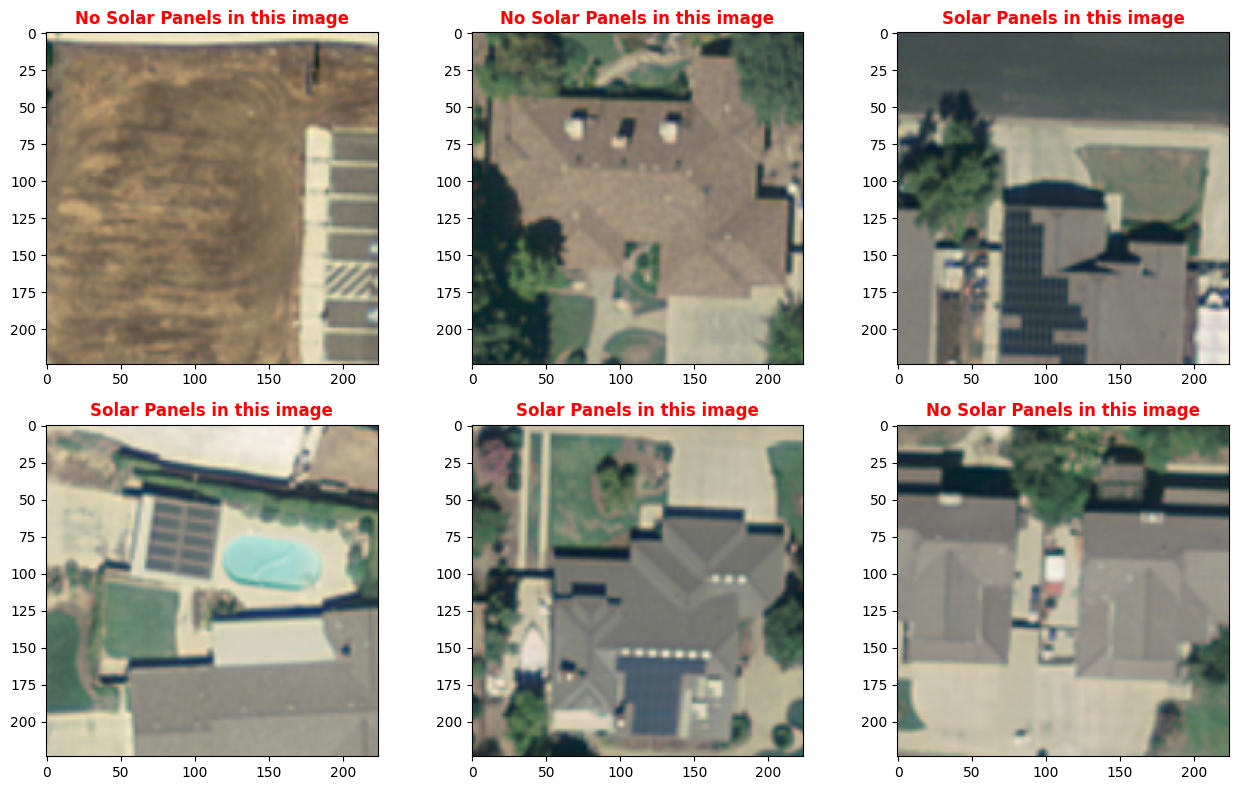

In [33]:
# display the images with and without solar panels
plt.figure(figsize=(13, 8))

for i in range(6):
    plt.subplot(2, 3, i + 1)

    # Undo EfficientNet preprocessing for visualization
    # EfficientNetB0 subtracts mean and divides by std — we need to reverse it
    img_vis = X[i].copy()
    img_vis = (img_vis - np.min(img_vis)) / (np.max(img_vis) - np.min(img_vis))  # Normalize to [0, 1]

    plt.imshow(img_vis)  # Corrected for visualization

    title = 'Solar Panels in this image' if y[i] == 1 else 'No Solar Panels in this image'
    plt.title(title, color='r', weight='bold')

plt.tight_layout()
plt.show()


In [34]:
# print data shape
print('X shape:\n', X.shape)

X shape:
 (1500, 224, 224, 3)


- 1500 total images in the training data
- Each image is of shape (101 x 101 x 3)

In [35]:
# check number of samples
print('Distribution of y', np.bincount(y))

Distribution of y [995 505]


- Out of 1500 images:
  - 995 images are without any solar panels
  - 505 images are with solar panels

# Building the CNN Model<a name ="h5"></a>

<p align="justify">A neural network type with a topology resembling a grid is known as a CNN. The effectiveness of CNNs in computer vision applications including image classification, picture clustering, and object identification is well recognised. Convolutional neural networks (CNNs) at least one of its layers instead of matrix multiplication at their core. They are structured like other neural networks by a series of layers. Neurons are grouped in three dimensions—width, height, and depth—in the layers of CNN. Although there are many various kinds of CNN architectures, they are the best option for picture identification since they handle pixels in relation to their surrounds.

<center> <img src = "https://miro.medium.com/max/1400/1*kkyW7BR5FZJq4_oBTx3OPQ.webp" width = 85%>

The convolutional layer applies a convolution operation, the output is passed to the next layer. The pool layer performs a down sampling operation by combining the outputs of neurons at one layer into a single neuron in the next layer. The flatten reshapes the feature map into a column. The full-connection layer will compute the class scores, each neuron in this layer will be connected to all the neurons in the previous one

*Credits* - [MathWorks](https://www.mathworks.com/videos/introduction-to-deep-learning-what-are-convolutional-neural-networks--1489512765771.html)

In [37]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam

def build_model():
    '''
    Returns a Keras model using EfficientNetB0 for binary classification
    '''
    # Define input shape
    IMAGE_HEIGHT = 224
    IMAGE_WIDTH = 224
    IMAGE_CHANNELS = 3
    input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

    # Load EfficientNetB0 base model with pretrained ImageNet weights
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)

    # Freeze the base model (you can unfreeze later for fine-tuning)
    base_model.trainable = False

    # Add custom top layers for classification
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, x)

    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    return model


##Checking the Performance of our CNN Model

In [38]:
# cross-validate CNN model
def cv_performance_assessment(X, y, num_folds, clf, random_seed=1):
    '''
    Cross validated performance assessment

    Input:
        X: training data
        y: training labels
        num_folds: number of folds for cross validation
        clf: classifier to use

    Divide the training data into k folds of training and validation data.
    For each fold the classifier will be trained on the training data and
    tested on the validation data. The classifier prediction scores are
    aggregated and output.
    '''

    prediction_scores = np.empty(y.shape[0], dtype='object')

    # establish the num_folds folds
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=random_seed)

    for train_index, val_index in kf.split(X, y):
        # extract the training and validation data for this fold
        X_train, X_val = X[train_index], X[val_index]
        y_train = y[train_index]

        # give more weight to minority class based on the target class distribution
        class_weight = {0: 505/1500, 1: 995/1500}

        # train the classifier
        training = clf.fit(x=X_train,
                           y=y_train,
                           class_weight=class_weight,
                           batch_size=32,
                           epochs=10,
                           shuffle=True,
                           verbose=1)

        # test the classifier on the validation data for this fold
        y_val_pred_probs = clf.predict(X_val).reshape((-1, ))

        # save the predictions for this fold
        prediction_scores[val_index] = y_val_pred_probs

    return prediction_scores

In [39]:
# number of subsets of data, where k subsets are used as test set and other k-1 subsets are used for the training purpose
num_folds = 3

# seed value is the previous value number generated by the random function
random_seed = 1

# build_model() function returns the predefined sequential model
cnn = build_model()

# lets look at summary of the model
cnn.summary()

# generate the probabilities (y_pred_prob)
cnn_y_hat_prob = cv_performance_assessment(X, y, num_folds, cnn, random_seed=random_seed)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 261ms/step - accuracy: 0.4345 - loss: 0.3203
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6830 - loss: 0.2796
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7812 - loss: 0.2429
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8134 - loss: 0.2228
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8055 - loss: 0.2135
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8442 - loss: 0.1930
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8658 - loss: 0.1785
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8623 - loss: 0.1703
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8525 - loss: 0.1583
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8599 - loss: 0.1612
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 440ms/step
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8577 - loss: 0.1633
Epoch 2/10
32/32 ━━━

Looking at the True Positives, False Negatives, False Positives & True Negatives -



In [45]:
df = pd.read_csv(DIR_TRAIN_LABELS)                                              # Create a data frame of labels
df["predicted_class"] = [1 if pred >= 0.5 else 0 for pred in cnn_y_hat_prob]    # Add a column for predicted class

# Get the values for FN, FP, TP, TN using the correct column name
fn = np.array(df[(df['label'] == 1) & (df['predicted_class'] == 0)]['id'])      # False Negative
fp = np.array(df[(df['label'] == 0) & (df['predicted_class'] == 1)]['id'])      # False Positive
tp = np.array(df[(df['label'] == 1) & (df['predicted_class'] == 1)]['id'])      # True Positive
tn = np.array(df[(df['label'] == 0) & (df['predicted_class'] == 0)]['id'])      # True Negative


In [46]:
def show_images(image_ids, num_images, title, color):
    '''
    Display a subset of images from the image_ids data
    '''
    rcParams['figure.figsize'] = 20, 4
    plt.figure()
    n = 1
    for i in image_ids[0:num_images]:
        plt.subplot(1, num_images, n)
        
        # Fix: normalize to [0, 1] for proper display
        img_vis = X[i]
        img_vis = (img_vis - np.min(img_vis)) / (np.max(img_vis) - np.min(img_vis))

        plt.imshow(img_vis)
        plt.title(f'Image id: {i}', fontsize=10)
        plt.axis('off')
        n += 1

    plt.suptitle('\n' + title, fontsize=15, color=color, weight='bold')
    plt.tight_layout()
    plt.show()


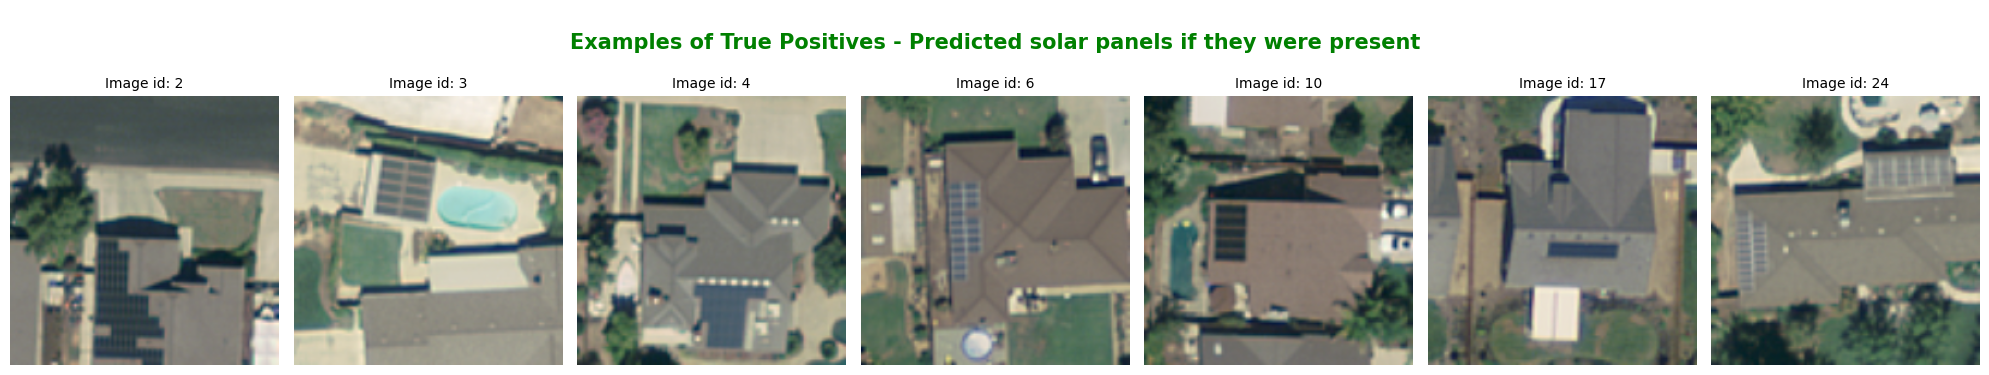

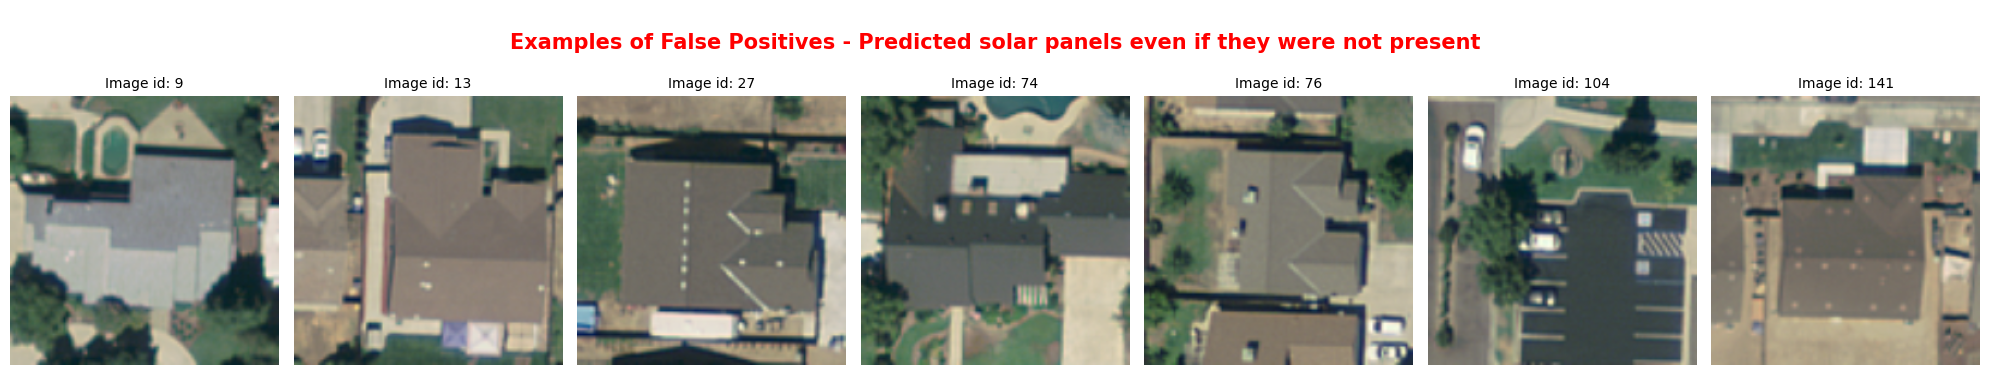

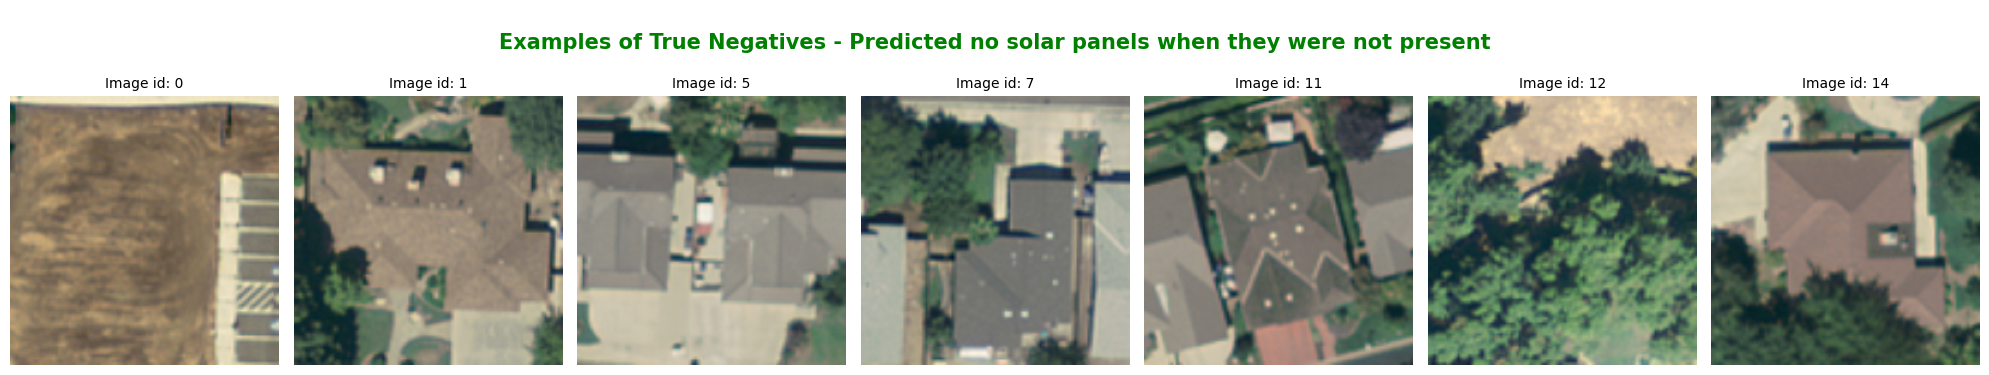

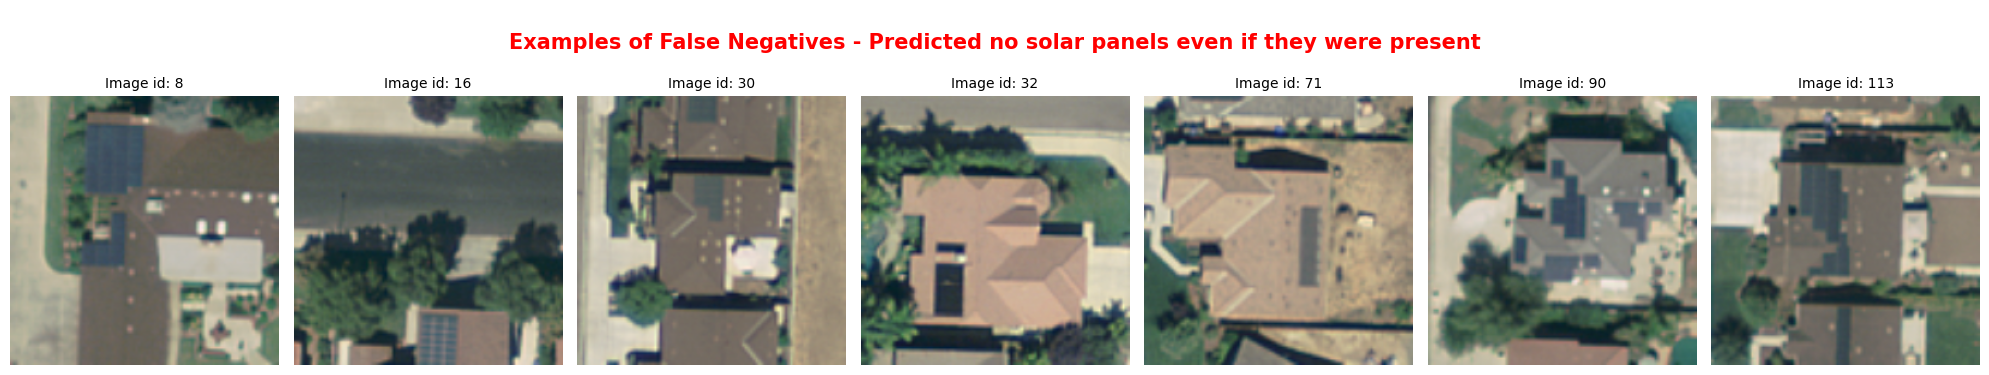

In [47]:
num_images = 7  # number of images to look at
show_images(tp, num_images, 'Examples of True Positives - Predicted solar panels if they were present', 'g')
show_images(fp, num_images, 'Examples of False Positives - Predicted solar panels even if they were not present', 'r')
show_images(tn, num_images, 'Examples of True Negatives - Predicted no solar panels when they were not present', 'g')
show_images(fn, num_images, 'Examples of False Negatives - Predicted no solar panels even if they were present', 'r')

# Model Evaluation & Results<a name ="h6"></a>

## Understanding ROC Curves -

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

*   True Positive Rate
*   False Positive Rate

<center>True Positive Rate (TPR) is a synonym for recall and is therefore defined as follows:

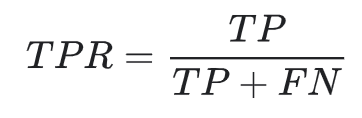

False Positive Rate (FPR) is defined as follows:

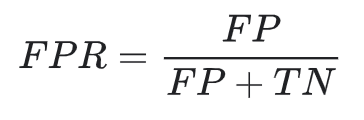

An ROC curve plots TPR vs. FPR at different classification thresholds.

Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives.</center>

#### AUC: Area Under the ROC Curve -
AUC stands for "Area under the ROC Curve." That is, AUC measures the entire two-dimensional area underneath the entire ROC curve from 0 to 1.
AUC provides an aggregate measure of performance across all possible classification thresholds. One way of interpreting AUC is as the **probability that the model ranks a random positive example more highly than a random negative example**. AUC ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0.

In [48]:
# ROC - AUC
def plot_roc(y_true, y_pred_cnn):
    '''
    Plots ROC curves for the CNN models.
    '''
    plt.figure(figsize=(8, 8))

    # ROC of CNN
    fpr, tpr, _ = roc_curve(y_true, y_pred_cnn, pos_label=1)
    auc = roc_auc_score(y_true, y_pred_cnn)
    legend_string = 'CNN Model - AUC = {:0.3f}'.format(auc)
    plt.plot(fpr, tpr, color='red', label=legend_string)

    # ROC of chance
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Chance - AUC = 0.5')

    # plot aesthetics
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid('on')
    plt.axis('square')
    plt.legend()
    plt.tight_layout()
    plt.title('ROC Curve', fontsize=10)
    pass

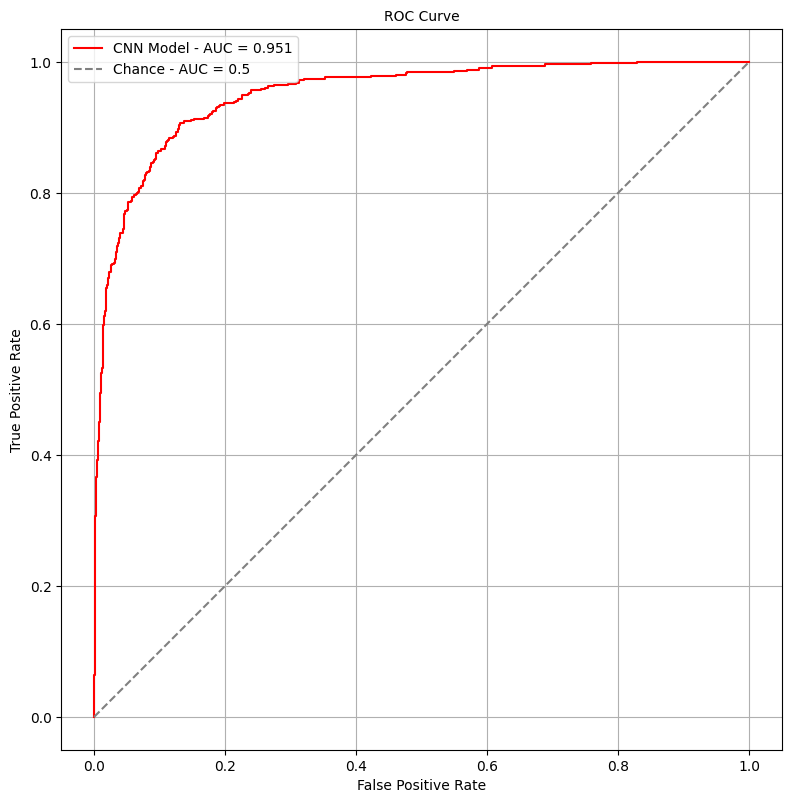

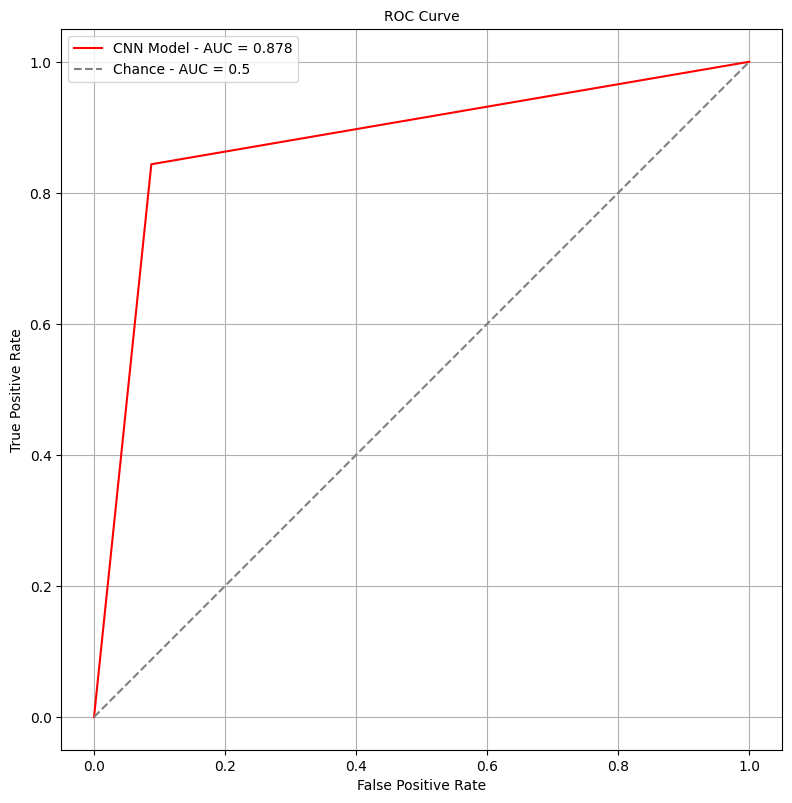

In [49]:
# plot ROC
y_pred = [1 if pred >= 0.5 else 0 for pred in cnn_y_hat_prob]
plot_roc(y,  cnn_y_hat_prob)
plot_roc(y, y_pred)

**CONFUSION MATRIX**         
<img src = 'https://miro.medium.com/v2/resize:fit:1218/1*jMs1RmSwnYgR9CsBw-z1dw.png'>

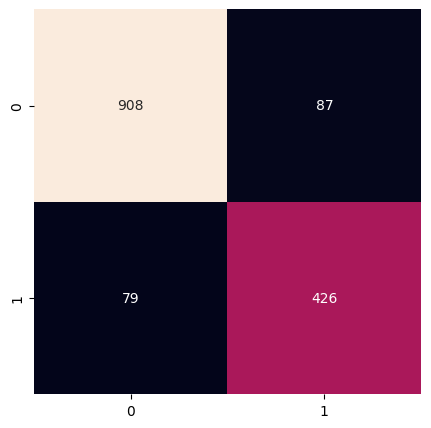

In [50]:
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y, y_pred), annot = True, cbar = False, fmt='.0f')
plt.show()

In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming `y` is the true labels and `y_pred` is the predicted class labels (0/1)
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)

# Format as percentage with 1 decimal
def percent(x):
    return f"{x * 100:.1f}%"

# Print metrics with verdicts
print(f"{'Metric':<12}{'Score':<10}{'Verdict'}")
print(f"{'-'*35}")
print(f"{'Accuracy':<12}{percent(accuracy):<10}✅ Excellent overall correctness")
print(f"{'Precision':<12}{percent(precision):<10}✅ Good — few false positives")
print(f"{'Recall':<12}{percent(recall):<10}✅ Strong — model catches most solar panels")
print(f"{'F1 Score':<12}{percent(f1):<10}✅ Balanced performance")


Metric      Score     Verdict
-----------------------------------
Accuracy    88.9%     ✅ Excellent overall correctness
Precision   83.0%     ✅ Good — few false positives
Recall      84.4%     ✅ Strong — model catches most solar panels
F1 Score    83.7%     ✅ Balanced performance
